<img src="http://oproject.org/img/ROOT.png" height="30%" width="30%">
<img src="http://oproject.org/img/tmvalogo.png" height="30%" width="30%">

<hr style="border-top-width: 4px; border-top-color: #34609b;">

# DNN Example

## Declare Factory

In [1]:
TFile* inputFile = TFile::Open("inputdata.root");
TFile* outputFile = TFile::Open("TMVAOutput.root", "RECREATE");

TMVA::Factory factory("TMVAClassification", outputFile,
                      "!V:ROC:!Correlations:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" ); 

## Declare DataLoader

In [2]:
TMVA::DataLoader loader("dataset_dnn");

loader.AddVariable("var1");
loader.AddVariable("var2");
loader.AddVariable("var3");
loader.AddVariable("var4");

## Setup Dataset(s)

In [3]:
TTree *tsignal = (TTree*) inputFile->Get("Sig");
TTree *tbackground = (TTree*) inputFile->Get("Bkg");

loader.AddSignalTree(tsignal);
loader.AddBackgroundTree(tbackground);
loader.PrepareTrainingAndTestTree("",
        "nTrain_Signal=1000:nTrain_Background=1000:SplitMode=Random:NormMode=NumEvents:!V"); 

DataSetInfo              : [dataset_dnn] : Added class "Signal"
                         : Add Tree Sig of type Signal with 6000 events
DataSetInfo              : [dataset_dnn] : Added class "Background"
                         : Add Tree Bkg of type Background with 6000 events
                         : Dataset[dataset_dnn] : Class index : 0  name : Signal
                         : Dataset[dataset_dnn] : Class index : 1  name : Background


# Configure network layout 

In [4]:
// General layout
TString inputLayoutString = "InputLayout=1|1|4"; 
TString batchLayoutString= "BatchLayout=1|128|4";
TString layoutString ("Layout=DENSE|32|RELU,DENSE|32|RELU,DENSE|32|RELU,DENSE|32|RELU,DENSE|1|LINEAR");

// Training strategies 
// one can catenate several training strategies 
TString training1("LearningRate=1e-3,Momentum=0.9,Repetitions=1,"
                        "ConvergenceSteps=20,BatchSize=128,TestRepetitions=1,"
                        "MaxEpochs=20,WeightDecay=1e-4,Regularization=L2,"
                        "Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.");
  
TString trainingStrategyString ("TrainingStrategy=");
trainingStrategyString += training1; // + "|" + training2 + "|" + training3;

// General Options.                                                                                                                                                                
TString dnnOptions ("!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"
                          "WeightInitialization=XAVIERUNIFORM");
dnnOptions.Append (":"); dnnOptions.Append (inputLayoutString);
dnnOptions.Append (":"); dnnOptions.Append (batchLayoutString);
dnnOptions.Append (":"); dnnOptions.Append (layoutString);
dnnOptions.Append (":"); dnnOptions.Append (trainingStrategyString);

dnnOptions += ":Architecture=Standard";

# Booking Methods

In [5]:


// Multi-Layer Perceptron (Neural Network)
factory.BookMethod(&loader, TMVA::Types::kMLP, "MLP",
        "!H:!V:NeuronType=tanh:VarTransform=N:NCycles=10:HiddenLayers=N+5:TestRate=5:!UseRegulator");

// Adaptive Boost Trees
factory.BookMethod(&loader, TMVA::Types::kBDT, "BDT",
                           "!H:!V:NTrees=850:MinNodeSize=2.5%:MaxDepth=3:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" );


//Deep Neural Network
factory.BookMethod(&loader, TMVA::Types::kDL, "DL_DENSE", dnnOptions);



Factory                  : Booking method: MLP
                         : 
MLP                      : [dataset_dnn] : Create Transformation "N" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
MLP                      : Building Network. 
                         : Initializing weights
Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset_dnn] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : -------------

## Train Methods

In [6]:
factory.TrainAllMethods();

Factory                  : Train all methods
Factory                  : [dataset_dnn] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
TFHandler_Factory        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var1:   0.089202     1.6614   [    -4.9583     4.3390 ]
                         :     var2:   0.094894     1.5721   [    -4.6474     3.9513 ]
                         :     var3:    0.10454     1.7350   [    -5.0373     4.2785 ]


                         :         15 |      0.34763    0.362363     0.08089   0.0553105       75060           1
                         :         16 Minimum Test error found - save the configuration 
                         :         16 |     0.347304    0.358705   0.0809823   0.0556623     75829.4           0
                         :         17 |     0.342784    0.360275   0.0807734   0.0558576     77059.5           1
                         :         18 Minimum Test error found - save the configuration 
                         :         18 |     0.346654    0.357146   0.0808519   0.0558651     76840.6           0
                         :         19 Minimum Test error found - save the configuration 
                         :         19 |      0.34186    0.355532   0.0802748   0.0552933     76856.9           0
                         :         20 Minimum Test error found - save the configuration 
                         :         20 |     0.341311    0.354503   0.0816735   

## Test and Evaluate Methods

In [7]:
factory.TestAllMethods();
factory.EvaluateAllMethods();    

Factory                  : Test all methods
Factory                  : Test method: MLP for Classification performance
                         : 
MLP                      : [dataset_dnn] : Evaluation of MLP on testing sample (10000 events)
                         : Elapsed time for evaluation of 10000 events: 0.0249 sec       
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset_dnn] : Evaluation of BDT on testing sample (10000 events)
                         : Elapsed time for evaluation of 10000 events: 0.626 sec       
Factory                  : Test method: DL_DENSE for Classification performance
                         : 
                         : Evaluate deep neural network on the STANDARD architecture  using batches with size = 1000
                         : 
DL_DENSE                 : [dataset_dnn] : Evaluation of DL_DENSE on testing sample (10000 events)
                         : Elap

## Plot ROC Curve
We enable JavaScript visualisation for the plots

In [8]:
%jsroot on

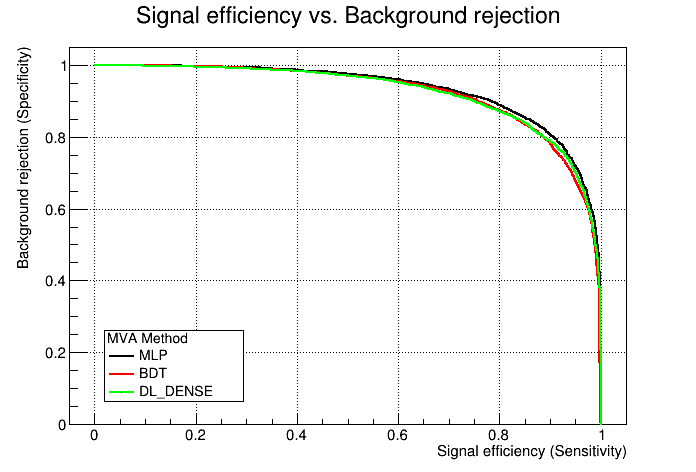

In [9]:
auto c2 = factory.GetROCCurve(&loader);
c2->Draw();